In [1]:
%run 'Functions.ipynb'

In [8]:
client = Elasticsearch()

In [3]:
ids = [e.meta.id for e in Search(index='hep-recent').fields(['_id']).scan()]

In [92]:
len(ids)

99999

In [65]:
def term_vectors(ids, field):
    res = client.mtermvectors(
        index='hep-recent', 
        doc_type='hep',
        ids=ids,
        fields=[field],
        field_statistics=False,
        term_statistics=True,
        offsets=False,
        payloads=False,
        positions=False
    )
    return [e['term_vectors'][field]['terms'] for e in res['docs'] if field in e['term_vectors']]

In [59]:
res = term_vectors(ids[0:100], 'abstracts.value')

In [27]:
word_freq = {}

In [69]:
for i in range(0, 100):
    vectors = term_vectors(ids[100 * i:100 * i + 100], 'abstracts.value')
    for vec in vectors:
        for word, freq in vec.items():
            if word not in word_freq:
                word_freq[word] = freq['ttf']

In [70]:
len(word_freq)

38128

In [55]:
word_freq

{'1.97': 12,
 'hot': 686,
 'ordered': 177,
 'demonstrating': 90,
 'use': 3093,
 'renormalizability': 51,
 'mission': 229,
 'sasso': 59,
 'locations': 92,
 'fifth': 116,
 'robert': 9,
 'ice': 125,
 'f': 1905,
 'did': 110,
 'quark': 3718,
 'astronomical': 151,
 'generalize': 234,
 'reconstruction': 536,
 'point': 2697,
 'acquire': 70,
 'g·cm': 1,
 'nonunitary': 12,
 'multisymplectic': 14,
 'candidates': 605,
 'atmospheric': 460,
 'much': 1117,
 'iue': 2,
 'technically': 37,
 'wider': 94,
 'ψ': 366,
 'complement': 91,
 'tests': 640,
 'front': 368,
 'nir': 90,
 'assumedparticle': 1,
 'list': 127,
 'xe': 68,
 'crossover': 152,
 'odd': 513,
 'expectation': 433,
 'generalized': 1007,
 'currently': 491,
 'null': 459,
 'b0': 94,
 'clover': 43,
 'interpolates': 45,
 'optimization': 152,
 'spiral': 293,
 'computations': 176,
 'radio': 2404,
 'anomalies': 216,
 'related': 1370,
 'works': 330,
 'breaking': 1275,
 'clear': 425,
 'compare': 1105,
 'agrees': 176,
 'calculable': 39,
 '1972': 4,
 'orbit

In [71]:
sorted(word_freq.items(), key=lambda x: -x[1])

[('the', 333720),
 ('of', 176415),
 ('and', 100900),
 ('in', 90590),
 ('a', 90321),
 ('to', 77976),
 ('we', 57647),
 ('is', 50309),
 ('for', 44621),
 ('with', 42040),
 ('that', 36403),
 ('are', 29645),
 ('by', 26821),
 ('on', 25563),
 ('this', 24363),
 ('at', 23297),
 ('as', 21618),
 ('from', 20980),
 ('be', 20223),
 ('an', 17475),
 ('mml:mi', 16684),
 ('which', 15593),
 ('model', 14475),
 ('can', 12576),
 ('inline', 12526),
 ('energy', 12306),
 ('mass', 12181),
 ('1', 11473),
 ('mml:mo', 11318),
 ('mml:mrow', 11118),
 ('2', 10977),
 ('formula', 10531),
 ('these', 10422),
 ('field', 10321),
 ('two', 10075),
 ('it', 10006),
 ('data', 9776),
 ('also', 9579),
 ('mml:math', 9224),
 ('results', 8907),
 ('using', 8764),
 ('our', 8618),
 ('have', 8409),
 ('mml:mn', 7718),
 ('between', 7482),
 ('theory', 7450),
 ('high', 7366),
 ('show', 7223),
 ('or', 7025),
 ('one', 6997),
 ('matter', 6940),
 ('time', 6766),
 ('has', 6669),
 ('study', 6588),
 ('models', 6584),
 ('new', 6575),
 ('find', 6549)

In [43]:
word_freq['higgs']

3767

In [81]:
from wordcloud import WordCloud

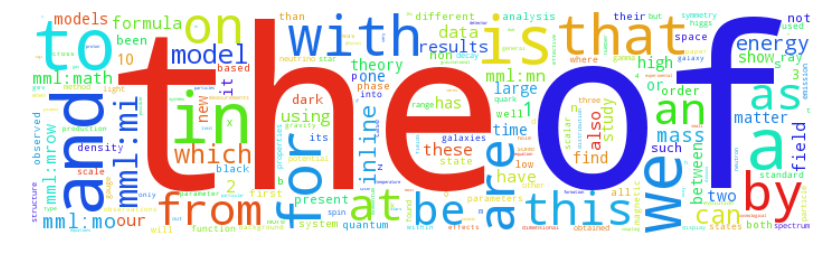

In [91]:
plt.axis("off")
plt.imshow(WordCloud(width=700, background_color='white').generate_from_frequencies(word_freq.items()))